# New ts_gen

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
from utils.meta_eval import TSGenArgs, create_ds_dict, plot_ds
from experiments.meta_eval.me import experiment

args = TSGenArgs()
args.n_epochs = 100
args.test_interval = 100
args.gnn_depth = 1
args.n_layers = 1
# args.remove_existing_data = True

exp_log = experiment(args)

Starting training...
100%|██████████| 843/843 [00:12<00:00, 69.20it/s]
Epoch 1: Training Loss 0.17394704844514974
100%|██████████| 843/843 [00:12<00:00, 69.72it/s]
Epoch 2: Training Loss 0.16684104599246322
100%|██████████| 843/843 [00:11<00:00, 70.70it/s]
Epoch 3: Training Loss 0.1664816083895406
100%|██████████| 843/843 [00:12<00:00, 69.48it/s]
Epoch 4: Training Loss 0.16559238238620222
100%|██████████| 843/843 [00:12<00:00, 69.27it/s]
Epoch 5: Training Loss 0.16479774831054467
100%|██████████| 843/843 [00:12<00:00, 67.43it/s]
Epoch 6: Training Loss 0.1642134560752394
100%|██████████| 843/843 [00:12<00:00, 68.22it/s]
Epoch 7: Training Loss 0.1638889665462483
100%|██████████| 843/843 [00:11<00:00, 71.15it/s]
Epoch 8: Training Loss 0.16309663288571805
100%|██████████| 843/843 [00:12<00:00, 69.13it/s]
Epoch 9: Training Loss 0.16288771602008079
100%|██████████| 843/843 [00:11<00:00, 71.14it/s]
Epoch 10: Training Loss 0.1625739248320735
100%|██████████| 843/843 [00:12<00:00, 68.25it/s]
Ep

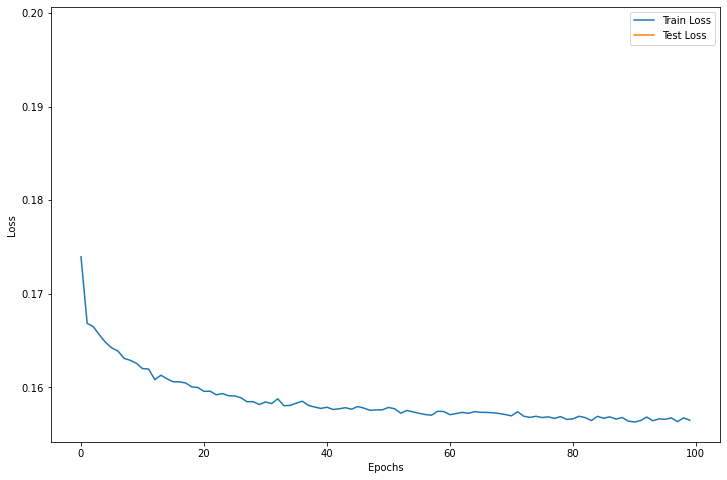

In [3]:
import numpy as np

def save_Ds(exp_log, file_name, save_to_log_dir = False, D_folder='experiments/meta_eval/d_inits/'):
    test_Ds = np.concatenate(exp_log.test_logs[-1].Ds, 0)[0:842] # final test log, new dim = num_rxns x 21 x 21
    assert len(test_Ds) == 842, f"Should have 842 test_D_inits when unbatched, you have {len(test_Ds)}."
    np.save(D_folder + file_name, test_Ds)
    if save_to_log_dir:
        np.save(exp_log.args.log_dir + 'D', test_Ds)

def save_Ws(exp_log, file_name, save_to_log_dir = False, W_folder='experiments/meta_eval/ws/'):
    test_Ws = np.concatenate(exp_log.test_logs[-1].Ws, 0)[0:842].squeeze() # final test log, and remove singleton dims; new dim = num_rxns x 21 x 21
    assert len(test_Ws) == 842, f"Should have 842 test_Ws when unbatched, you have {len(test_Ws)}."
    np.save(W_folder + file_name, test_Ws)
    if save_to_log_dir:
        np.save(exp_log.args.log_dir + 'W', test_Ws)

file_name = '4.npy'
save_Ds(exp_log, file_name, save_to_log_dir=True)
save_Ws(exp_log, file_name, True)
exp_log.plot_loss(save_fig = True)

In [3]:
file_name = '8.npy'
#exp_log.save_Ds(file_name, save_to_log_dir=True)
#exp_log.save_Ws(file_name, save_to_log_dir=True)
# exp_log.plot_loss(save_fig = True)

AssertionError: Should have 842 test_D_inits when unbatched, you have 1684.

/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

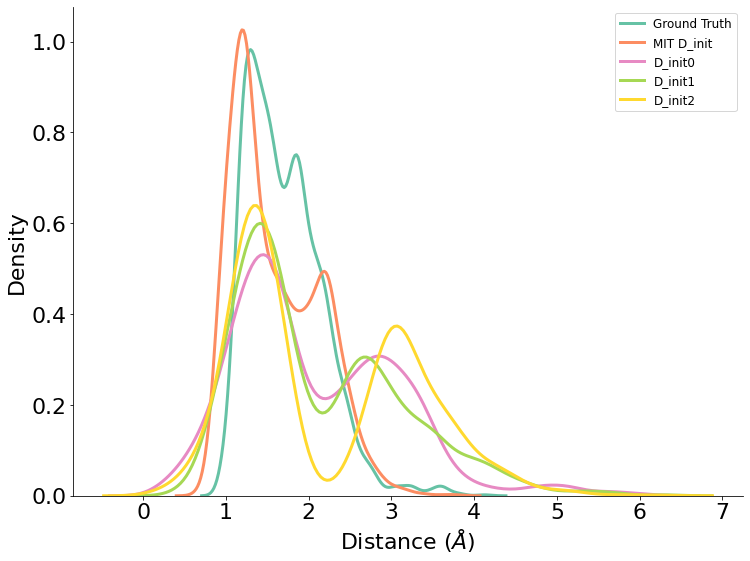

In [8]:
import os

# create ds_dict and plot d_inits
mols_folder = 'data/raw/'
d_folder = 'experiments/meta_eval/d_inits/'
d_plot_name = None # os.path.join(os.path.dirname(args.log_dir), 'dplot') # None won't save fig

ens_plot_folder = 'experiments/meta_eval/ens_figs/'
ens_plot_name = os.path.join(os.path.dirname(ens_plot_folder), 'opt') # None won't save fig

# standard: 1(e=100,t=2500s),  5(e=50, t=1900s), 6(e=100, t=3850s)

# e=100,b=8,h=256, g/l 
# 09/08: no init (dw): 2(2500, 32), 3(2100s, 22), 4(1200, 11) 
# 09/08 no opt (pow): 6(3700, 32), 7(t=3500, 22) 8(t=2400, 11)
# 09/08: full (opt): 9(3900, 32), 10(3600, 22), 1(?, 11)
d_files = ['9.npy', '10.npy', '1.npy'] 
ds_not_to_print = ['lin_approx']
ds_dict = create_ds_dict(d_files, d_folder, mols_folder) # TODO: create default d_init class for these?
plot_ds(ds_dict, ds_not_to_print, ens_plot_name)

## Ensemble

Average all produced $D_{inits}s$ then plot.

/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

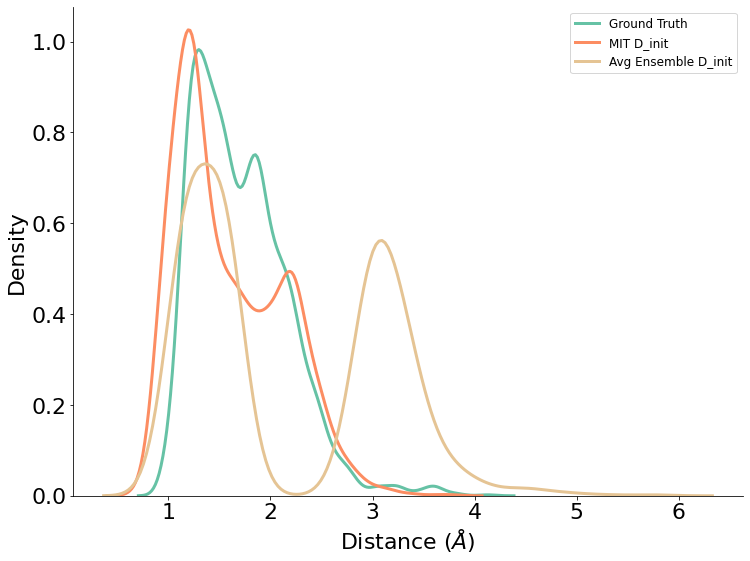

In [11]:
# from utils.meta_eval import ensemble_plot

d_files = ['2.npy', '3.npy', '4.npy'] 
ds_dict = create_ds_dict(d_files, d_folder, mols_folder)
ds_not_to_print = ['lin_approx']

NUM_STD_DS = 3

def ensemble_plot(ds_dict, ds_not_to_print, print_my_ds = False, name = None):
    num_my_ds = len(ds_dict) - NUM_STD_DS
    ens_ds = []
    for i in range(len(ds_dict['mit'][0])):
        ens_d = 0
        for j in range(0, num_my_ds):
            ens_d += ds_dict[f'D_init{j}'][0][i]
        ens_d /= num_my_ds
        ens_ds.append(ens_d)
    ds_dict['ens'] = (ens_ds, "Avg Ensemble D_init")

    if not print_my_ds:
        for j in range(0, num_my_ds):
            ds_not_to_print.append(f'D_init{j}')

    plot_ds(ds_dict, ds_not_to_print, name)

ens_plot_name = os.path.join(os.path.dirname(ens_plot_folder), 'dw-ens')
ensemble_plot(ds_dict, ds_not_to_print, name = ens_plot_name)